# Imports

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sci

# Definitions

In [61]:
class Parabolic:
    def __init__(self, N, case, x, u0, a_type, b_type):
        self.N = N
        self.case = case
        self.x = x
        self.u0 = u0
        self.a_type = a_type
        self.b_type = b_type


    def cd(self, x):
        if self.case == 0 or self.case == 1 or self.case == 4:
            return 1
        if self.case == 2 or self.case == 5:
            return x
        if self.case == 3:
            return x ** 2

    def f(self, x, u):
        if self.case == 4:
            return u
        else:
            return 0

    def u_a(self, case):
        if self.case == 0:
            return 1
        return 0
    
    def u_b(self, case):
        if self.case == 4:
            return 0
        return 1

In [62]:
class SimTime:
    def __init__(self, time, dt, tol, grow_fac, shrink_fac, dtmin, dtmax, endTime, stepsSinceRej, stepsRej, stepsAcc):
        self.time = time
        self.dt = dt
        self.tol = tol
        self.grow_fac = grow_fac
        self.shrink_fac = shrink_fac
        self.dtmin = dtmin
        self.dtmax = dtmax
        self.endTime = endTime
        self.stepsSinceRej = stepsSinceRej
        self.stepsRej = stepsRej
        self.stepsAcc = stepsAcc

In [63]:
### Number of intervals in mesh
N = 30

### p(x) for defining intervals
def p(x):
    return x + 0.9 * x * (1 - x)

### x[i]
x = np.zeros(N + 1)
for i in range(N + 1):
    x[i] = p(i / N)

grow_fac = 1.25
shrink_fac = 0.8
tol = 1 * (10 ** -2)
dtmin = 1 * (10 ** -4)
dtmax = 1 * (10 ** -1)

# Residual

In [86]:
def resid(U, dU, t, dt, case, para):
    W = U + dU
    res = np.zeros(N + 1)
    for i in range(0, N):
        Wmid = (W[i] + W[i+1]) / 2
        xmid = (x[i] + x[i+1]) / 2
        dx = x[i+1] - x[i]
        res[i] += para.cd(xmid) * dx/dt * (1/3 * dU[i] + 1/6 * dU[i+1]) + para.cd(xmid) / dx * (W[i] - W[i+1]) - para.f(xmid, Wmid) * dx/2
        res[i+1] += para.cd(xmid) * dx/dt * (1/6 * dU[i] + 1/3 * dU[i+1]) + para.cd(xmid) / dx * (W[i+1] - W[i]) - para.f(xmid, Wmid) * dx/2

    ## Boundary conditions
    if para.a_type == "D":
        res[0] = W[0] - para.u_a(case)
    if para.a_type == "N":
        res[0] -= para.u_a(case)
    if para.b_type == "D":
        res[-1] = W[-1] - para.u_b(case)
    if para.b_type == "N":
        res[-1] += para.u_b(case)
        
    return res

# Construction of C

In [83]:
def c(U, t, dt, case, para):
    Cdata = np.zeros((3, N+1))
    dU = np.zeros(N+1)
    Rbase = resid(U, dU, t, dt, case, para)
    epsilon = 1 * (10 ** (-6))
    for k in range(3):
        dU = np.zeros(N+1)
        for i in range(k, N+1, 3):
            dU[i] += epsilon
        R = (resid(U, dU, t, dt, case, para) - Rbase) / epsilon
        for i in range(k, N+1, 3):
            Cdata[0][i] = R[i-1]
            Cdata[1][i] = R[i]
            if i == N:
                break
            Cdata[2][i] = R[i+1]
        Cdata[0][0] = 0
    return Cdata

# Iterating

In [88]:
def step(start, stop, U, dt, case, para):
    triv = 1 * (10 ** -6) * dt
    t = start
    zeros = np.zeros(N+1)
    dU = np.zeros(len(U))
    while t < stop - triv:
        r = resid(U, zeros, t, dt, case, para)
        C = c(U, t, dt, case, para)
        dU = sci.solve_banded((1,1), C, -r)
        U += dU
        t += dt
    return (U, dU)

# Time Step

In [81]:
def copy(old):
    new = np.zeros(len(old))
    for i in range(len(old)):
        new[i] = old[i]
    return new

def advance(simTime, paraS, paraD, U, case):
    triv = 1 * (10 ** -6) * simTime.dtmin
    timeList = [simTime.time]
    dtList = [simTime.dt]
    errList = []
    UaList = [U[0]]
    UbList = [U[-1]]
    U = copy(paraS.u0)
    while simTime.time < simTime.endTime - triv:
        US = copy(U)
        UD = copy(U)
        start = simTime.time
        dt = simTime.dt
        stop = start + dt
        S = step(start, stop, US, dt, case, paraS)[0]
        D = step(start, stop, UD, dt / 2, case, paraD)[0]
        diff = abs(S - D)
        e_i = max(diff)
        errList.append(e_i)
        if e_i > simTime.tol and simTime.dt > simTime.dtmin:
            simTime.dt = max(simTime.dtmin, simTime.dt / 2)
            simTime.stepsSinceRej = 0
            simTime.stepsRej += 1
            continue
        else:
            simTime.stepsAcc += 1
            simTime.stepsSinceRej += 1
            simTime.time += simTime.dt
            U = 2 * D - S
            if e_i > 0.75 * simTime.tol:
                simTime.dt *= simTime.shrink_fac
            elif e_i < 0.25 * simTime.tol:
                if simTime.stepsSinceRej > 1:
                    simTime.dt *= simTime.grow_fac
            simTime.dt = min(simTime.dtmax, max(simTime.dt, simTime.dtmin))
            if simTime.time + simTime.dt > simTime.endTime:
                simTime.dt = simTime.endTime - simTime.time
            elif simTime.time + 2 * simTime.dt > simTime.endTime:
                simTime.dt = (simTime.endTime - simTime.time) / 2
        timeList.append(simTime.time)
        dtList.append(simTime.dt)
        UaList.append(U[0])
        UbList.append(U[-1])
    return (U, timeList, dtList, errList, UaList, UbList)

# Case 0

[-2.00000000e+00  0.00000000e+00  0.00000000e+00  1.11022302e-16
 -1.11022302e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.11022302e-16  0.00000000e+00
 -1.11022302e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.00000000e+00]
[-2.00000000e+00  0.00000000e+00  0.00000000e+00  1.11022302e-16
 -1.11022302e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.11022302e-16  0.00000000e+00
 -1.11022302e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.0000

/var/folders/2y/vjm7v16d4db4mxgvn7m9c36m0000gn/T/ipykernel_20399/2163243592.py:22: RuntimeWarning: divide by zero encountered in log10
  log[i] = np.log10(dtAdv[i])


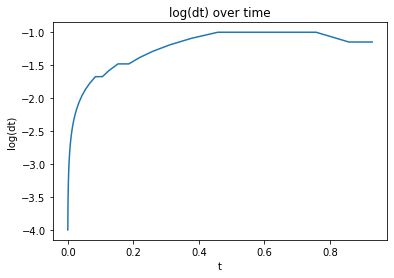

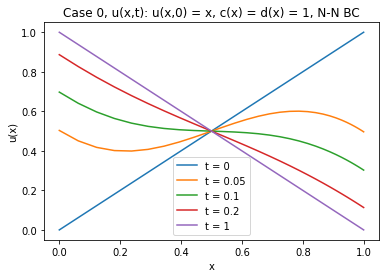

In [92]:
### Case 0

u0 = x

problem0a = Parabolic(N, 0, x, u0, "N", "N")
problem0b = Parabolic(N, 0, x, u0, "N", "N")
problem0S = Parabolic(N, 0, x, u0, "N", "N")
problem0D = Parabolic(N, 0, x, u0, "N", "N")

dt = dtmin
case0ST = SimTime(0, 1e-4, tol, grow_fac, shrink_fac, dtmin, dtmax, 1, 0, 0, 0)
u0a = copy(u0)
fig, ax = plt.subplots()
ax.set_title('log(dt) over time')
ax.set_xlabel('t')
ax.set_ylabel('log(dt)')
adv = advance(case0ST, problem0S, problem0D, u0a, 0)
timeAdv = adv[1]
dtAdv = adv[2]
log = np.zeros(len(dtAdv))
for i in range(len(dtAdv)):
    log[i] = np.log10(dtAdv[i])
ax.plot(timeAdv, log, label='log(dt)')

case0a = SimTime(0, dtmin, tol, grow_fac, shrink_fac, dtmin, dtmax, 0, 0, 0, 0)
case0b = SimTime(0, dtmin, tol, grow_fac, shrink_fac, dtmin, dtmax, 0.05, 0, 0, 0)
case0c = SimTime(0, dtmin, tol, grow_fac, shrink_fac, dtmin, dtmax, 0.1, 0, 0, 0)
case0d = SimTime(0, dtmin, tol, grow_fac, shrink_fac, dtmin, dtmax, 0.2, 0, 0, 0)
case0e = SimTime(0, dtmin, tol, grow_fac, shrink_fac, dtmin, dtmax, 1, 0, 0, 0)

fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.set_title('Case 0, u(x,t): u(x,0) = x, c(x) = d(x) = 1, N-N BC')
ax.plot(x, advance(case0a, problem0a, problem0b, u0, 0)[0], label='t = 0')
ax.plot(x, advance(case0b, problem0a, problem0b, u0, 0)[0], label='t = 0.05')
ax.plot(x, advance(case0c, problem0a, problem0b, u0, 0)[0], label='t = 0.1')
ax.plot(x, advance(case0d, problem0a, problem0b, u0, 0)[0], label='t = 0.2')
ax.plot(x, advance(case0e, problem0a, problem0b, u0, 0)[0], label='t = 1')
ax.legend()

# Case 1

/var/folders/2y/vjm7v16d4db4mxgvn7m9c36m0000gn/T/ipykernel_20399/2744437397.py:23: RuntimeWarning: divide by zero encountered in log10
  log[i] = np.log10(dtAdv[i])


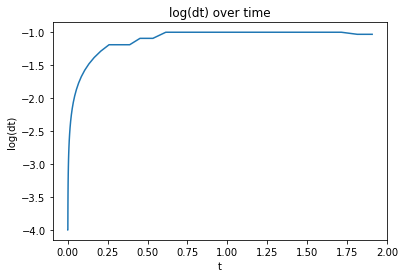

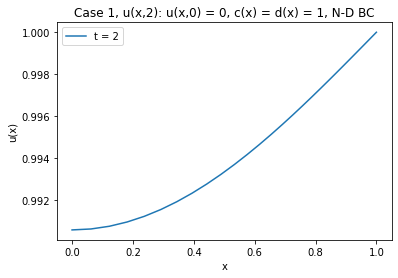

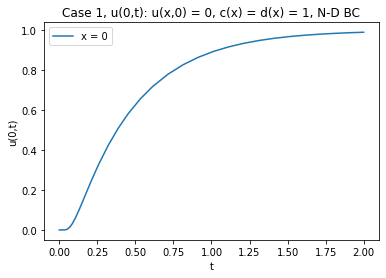

In [46]:
### Case 1

u1 = np.zeros(N+1)
x1 = np.arange(0, 2)

problem1a = Parabolic(N, 1, x, u1, "N", "D")
problem1b = Parabolic(N, 1, x, u1, "N", "D")
problem1S = Parabolic(N, 1, x, u1, "N", "D")
problem1D = Parabolic(N, 1, x, u1, "N", "D")

dt = dtmin
case1ST = SimTime(0, 1e-4, tol, grow_fac, shrink_fac, dtmin, dtmax, 2, 0, 0, 0)
u1a = copy(u1)
fig, ax = plt.subplots()
ax.set_title('log(dt) over time')
ax.set_xlabel('t')
ax.set_ylabel('log(dt)')
adv = advance(case1ST, problem1S, problem1D, u1a, 1)
timeAdv = adv[1]
dtAdv = adv[2]
log = np.zeros(len(dtAdv))
for i in range(len(dtAdv)):
    log[i] = np.log10(dtAdv[i])
ax.plot(timeAdv, log, label='log(dt)')

case1a = SimTime(0, dtmin, tol, grow_fac, shrink_fac, dtmin, dtmax, 2, 0, 0, 0)
case1 = advance(case1a, problem1a, problem1b, u1, 1)

fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.set_title('Case 1, u(x,2): u(x,0) = 0, c(x) = d(x) = 1, N-D BC')
ax.plot(x, case1[0], label='t = 2')
ax.legend()

fig, ax = plt.subplots()
ax.set_xlabel('t')
ax.set_ylabel('u(0,t)')
ax.set_title('Case 1, u(0,t): u(x,0) = 0, c(x) = d(x) = 1, N-D BC')
ax.plot(case1[1], case1[4], label='x = 0')
ax.legend()

# Case 2

/var/folders/2y/vjm7v16d4db4mxgvn7m9c36m0000gn/T/ipykernel_20399/627768121.py:22: RuntimeWarning: divide by zero encountered in log10
  log[i] = np.log10(dtAdv[i])


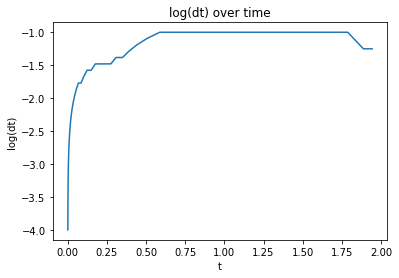

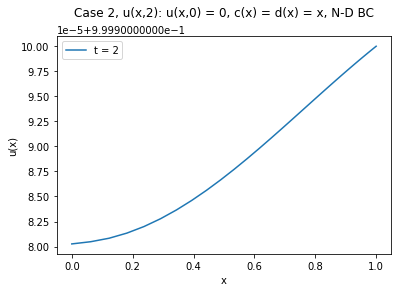

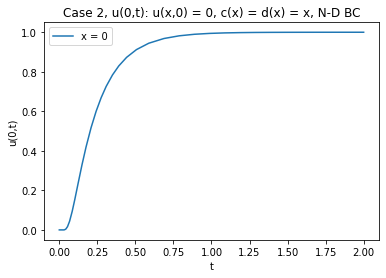

In [47]:
### Case 2

u2 = np.zeros(N+1)

problem2a = Parabolic(N, 2, x, u2, "N", "D")
problem2b = Parabolic(N, 2, x, u2, "N", "D")
problem2S = Parabolic(N, 2, x, u2, "N", "D")
problem2D = Parabolic(N, 2, x, u2, "N", "D")

dt = dtmin
case2ST = SimTime(0, 1e-4, tol, grow_fac, shrink_fac, dtmin, dtmax, 2, 0, 0, 0)
u2a = copy(u2)
fig, ax = plt.subplots()
ax.set_title('log(dt) over time')
ax.set_xlabel('t')
ax.set_ylabel('log(dt)')
adv = advance(case2ST, problem2S, problem2D, u2a, 2)
timeAdv = adv[1]
dtAdv = adv[2]
log = np.zeros(len(dtAdv))
for i in range(len(dtAdv)):
    log[i] = np.log10(dtAdv[i])
ax.plot(timeAdv, log, label='log(dt)')

case2a = SimTime(0, dtmin, tol, grow_fac, shrink_fac, dtmin, dtmax, 2, 0, 0, 0)
case2 = advance(case2a, problem2a, problem2b, u2, 2)

fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.set_title('Case 2, u(x,2): u(x,0) = 0, c(x) = d(x) = x, N-D BC', pad=20)
ax.plot(x, case2[0], label='t = 2')
ax.legend()

fig, ax = plt.subplots()
ax.set_xlabel('t')
ax.set_ylabel('u(0,t)')
ax.set_title('Case 2, u(0,t): u(x,0) = 0, c(x) = d(x) = x, N-D BC')
ax.plot(case2[1], case2[4], label='x = 0')
ax.legend()

# Case 3

/var/folders/2y/vjm7v16d4db4mxgvn7m9c36m0000gn/T/ipykernel_20399/2871129160.py:22: RuntimeWarning: divide by zero encountered in log10
  log[i] = np.log10(dtAdv[i])


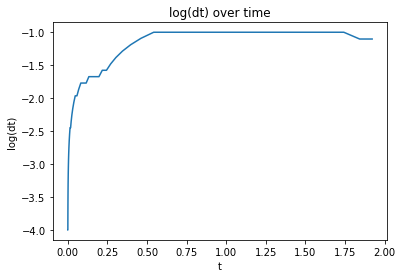

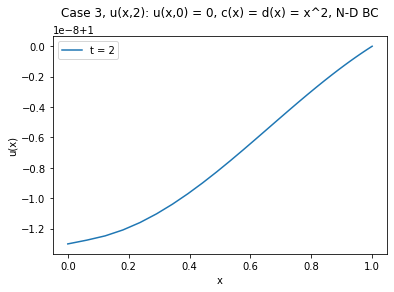

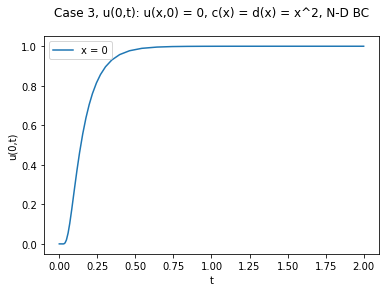

In [48]:
### Case 3

u3 = np.zeros(N+1)

problem3a = Parabolic(N, 3, x, u2, "N", "D")
problem3b = Parabolic(N, 3, x, u2, "N", "D")
problem3S = Parabolic(N, 3, x, u2, "N", "D")
problem3D = Parabolic(N, 3, x, u2, "N", "D")

dt = dtmin
case3ST = SimTime(0, 1e-4, tol, grow_fac, shrink_fac, dtmin, dtmax, 2, 0, 0, 0)
u3a = copy(u3)
fig, ax = plt.subplots()
ax.set_title('log(dt) over time')
ax.set_xlabel('t')
ax.set_ylabel('log(dt)')
adv = advance(case3ST, problem3S, problem3D, u3a, 3)
timeAdv = adv[1]
dtAdv = adv[2]
log = np.zeros(len(dtAdv))
for i in range(len(dtAdv)):
    log[i] = np.log10(dtAdv[i])
ax.plot(timeAdv, log, label='log(dt)')

case3a = SimTime(0, dtmin, tol, grow_fac, shrink_fac, dtmin, dtmax, 2, 0, 0, 0)
case3 = advance(case3a, problem3a, problem3b, u3, 3)

fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.set_title('Case 3, u(x,2): u(x,0) = 0, c(x) = d(x) = x^2, N-D BC', pad=20)
ax.plot(x, case3[0], label='t = 2')
ax.legend()

fig, ax = plt.subplots()
ax.set_xlabel('t')
ax.set_ylabel('u(0,t)')
ax.set_title('Case 3, u(0,t): u(x,0) = 0, c(x) = d(x) = x^2, N-D BC', pad = 20)
ax.plot(case3[1], case3[4], label='x = 0')
ax.legend()

# Case 4

/var/folders/2y/vjm7v16d4db4mxgvn7m9c36m0000gn/T/ipykernel_20399/109457111.py:22: RuntimeWarning: divide by zero encountered in log10
  log[i] = np.log10(dtAdv[i])


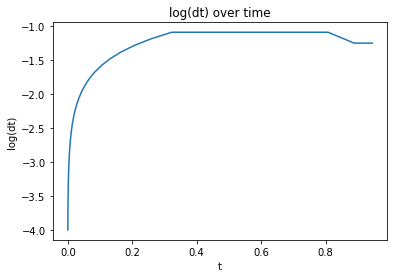

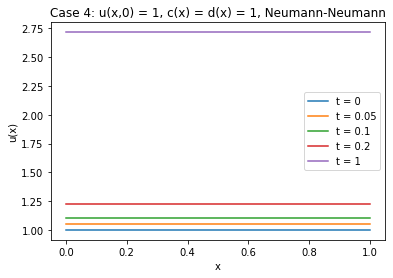

In [49]:
### Case 4

u4 = np.ones(N+1)

problem4a = Parabolic(N, 4, x, u4, "N", "N")
problem4b = Parabolic(N, 4, x, u4, "N", "N")
problem4S = Parabolic(N, 4, x, u4, "N", "N")
problem4D = Parabolic(N, 4, x, u4, "N", "N")

dt = dtmin
case4ST = SimTime(0, 1e-4, tol, grow_fac, shrink_fac, dtmin, dtmax, 1, 0, 0, 0)
u4a = copy(u4)
fig, ax = plt.subplots()
ax.set_title('log(dt) over time')
ax.set_xlabel('t')
ax.set_ylabel('log(dt)')
adv = advance(case4ST, problem4S, problem4D, u4a, 4)
timeAdv = adv[1]
dtAdv = adv[2]
log = np.zeros(len(dtAdv))
for i in range(len(dtAdv)):
    log[i] = np.log10(dtAdv[i])
ax.plot(timeAdv, log, label='log(dt)')

case4a = SimTime(0, dtmin, tol, grow_fac, shrink_fac, dtmin, dtmax, 0, 0, 0, 0)
case4b = SimTime(0, dtmin, tol, grow_fac, shrink_fac, dtmin, dtmax, 0.05, 0, 0, 0)
case4c = SimTime(0, dtmin, tol, grow_fac, shrink_fac, dtmin, dtmax, 0.1, 0, 0, 0)
case4d = SimTime(0, dtmin, tol, grow_fac, shrink_fac, dtmin, dtmax, 0.2, 0, 0, 0)
case4e = SimTime(0, dtmin, tol, grow_fac, shrink_fac, dtmin, dtmax, 1, 0, 0, 0)

fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.set_title('Case 4: u(x,0) = 1, c(x) = d(x) = 1, Neumann-Neumann')
ax.plot(x, advance(case4a, problem4a, problem4b, u4, 4)[0], label='t = 0')
ax.plot(x, advance(case4b, problem4a, problem4b, u4, 4)[0], label='t = 0.05')
ax.plot(x, advance(case4c, problem4a, problem4b, u4, 4)[0], label='t = 0.1')
ax.plot(x, advance(case4d, problem4a, problem4b, u4, 4)[0], label='t = 0.2')
ax.plot(x, advance(case4e, problem4a, problem4b, u4, 4)[0], label='t = 1')
ax.legend()

# Case 5

/var/folders/2y/vjm7v16d4db4mxgvn7m9c36m0000gn/T/ipykernel_20399/41810051.py:23: RuntimeWarning: divide by zero encountered in log10
  log[i] = np.log10(dtAdv[i])


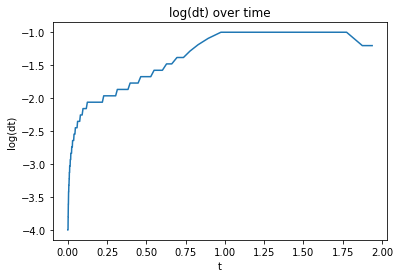

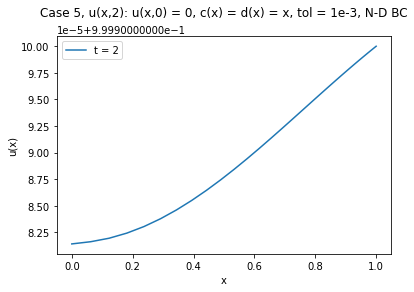

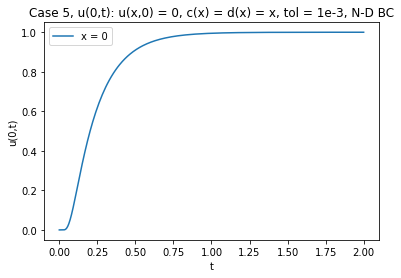

In [50]:
### Case 5

u5 = np.zeros(N+1)
tol5 = 1 * (10 ** -3)

problem5a = Parabolic(N, 5, x, u5, "N", "D")
problem5b = Parabolic(N, 5, x, u5, "N", "D")
problem5S = Parabolic(N, 5, x, u5, "N", "D")
problem5D = Parabolic(N, 5, x, u5, "N", "D")

dt = dtmin
case5ST = SimTime(0, 1e-4, tol5, grow_fac, shrink_fac, dtmin, dtmax, 2, 0, 0, 0)
u5a = copy(u5)
fig, ax = plt.subplots()
ax.set_title('log(dt) over time')
ax.set_xlabel('t')
ax.set_ylabel('log(dt)')
adv = advance(case5ST, problem5S, problem5D, u5a, 5)
timeAdv = adv[1]
dtAdv = adv[2]
log = np.zeros(len(dtAdv))
for i in range(len(dtAdv)):
    log[i] = np.log10(dtAdv[i])
ax.plot(timeAdv, log, label='log(dt)')

case5a = SimTime(0, dtmin, tol5, grow_fac, shrink_fac, dtmin, dtmax, 2, 0, 0, 0)
case5 = advance(case5a, problem5a, problem5b, u5, 5)

fig, ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('u(x)')
ax.set_title('Case 5, u(x,2): u(x,0) = 0, c(x) = d(x) = x, tol = 1e-3, N-D BC', pad=20)
ax.plot(x, case5[0], label='t = 2')
ax.legend()

fig, ax = plt.subplots()
ax.set_xlabel('t')
ax.set_ylabel('u(0,t)')
ax.set_title('Case 5, u(0,t): u(x,0) = 0, c(x) = d(x) = x, tol = 1e-3, N-D BC')
ax.plot(case5[1], case5[4], label='x = 0')
ax.legend()